In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse.linalg import svds

In [2]:
data = pd.read_csv('amazon.tsv', sep='\t', nrows=50_000)
print(data.describe())

        customer_id  product_parent   star_rating  helpful_votes   total_votes
count  5.000000e+04    5.000000e+04  50000.000000   50000.000000  50000.000000
mean   3.373975e+07    4.968622e+08      4.199060       9.073440     12.798220
std    1.476942e+07    2.880145e+08      1.229872      24.437768     28.474507
min    1.206538e+07    6.430000e+03      1.000000       0.000000      0.000000
25%    2.032599e+07    2.444445e+08      4.000000       1.000000      3.000000
50%    3.440894e+07    4.924436e+08      5.000000       4.000000      6.000000
75%    4.979659e+07    7.469139e+08      5.000000       9.000000     14.000000
max    5.309658e+07    9.999940e+08      5.000000    1887.000000   1924.000000


## INITIAL EXPLORATION AND DATA ANALYSIS

In [3]:
print("---- data.head() ----")
print(data.head(2))
print()

print("---- Columns ----")
num_cols = data.select_dtypes(exclude=["object"]).columns
cat_cols = data.select_dtypes(include=["object"]).columns
print(f"There are {len(num_cols)} Numeric columns in the DF")
for col in num_cols:
    print(f"  - {col}")
print()
print(f"There are {len(cat_cols)} Categorical columns in the DF ")
for col in cat_cols:
    print(f"  - {col}")
print()

print("---- Missing values ----")
missing = data.isnull().sum()
print(missing)
print()

print("---- Unique values ----")
unique = data.nunique()
print(unique)
print()

print("---- Low variance columns ----")
var = data.select_dtypes(include=[np.number]).var()
var_threshold = 0.01
cols_with_low_var = var[var < var_threshold].index.tolist()
print(f"There are {len(cols_with_low_var)} columns with low variance")
for col in cols_with_low_var:
    print(f"  - {col}")
print()


---- data.head() ----
  marketplace  customer_id      review_id  product_id  product_parent  \
0          US     12076615  RQ58W7SMO911M  0385730586       122662979   
1          US     12703090   RF6IUKMGL8SF  0811828964        56191234   

                                   product_title product_category  \
0     Sisterhood of the Traveling Pants (Book 1)            Books   
1  The Bad Girl's Guide to Getting What You Want            Books   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0            4              2            3    N                 N   
1            3              5            5    N                 N   

                         review_headline review_date  
0  this book was a great learning novel!  2005-10-14  
1                              Fun Fluff  2005-10-14  

---- Columns ----
There are 5 Numeric columns in the DF
  - customer_id
  - product_parent
  - star_rating
  - helpful_votes
  - total_votes

There are 9 Categorical columns in

In [4]:
# Drop columns with missing values
data.dropna(inplace=True)

# Stay with only relevant columns
data = data[['customer_id', 'product_id', 'star_rating', 'verified_purchase','review_date', 'product_category', 'helpful_votes', 'total_votes']]

## Train, test, validation split and preprocessing

Train shape: (34990, 7)
Validation shape: (7498, 7)
Test shape: (7499, 7)

Skewness of the numerical variables in the training set
customer_id      -0.095539
star_rating      -1.518693
helpful_votes    24.445647
total_votes      18.506025
dtype: float64



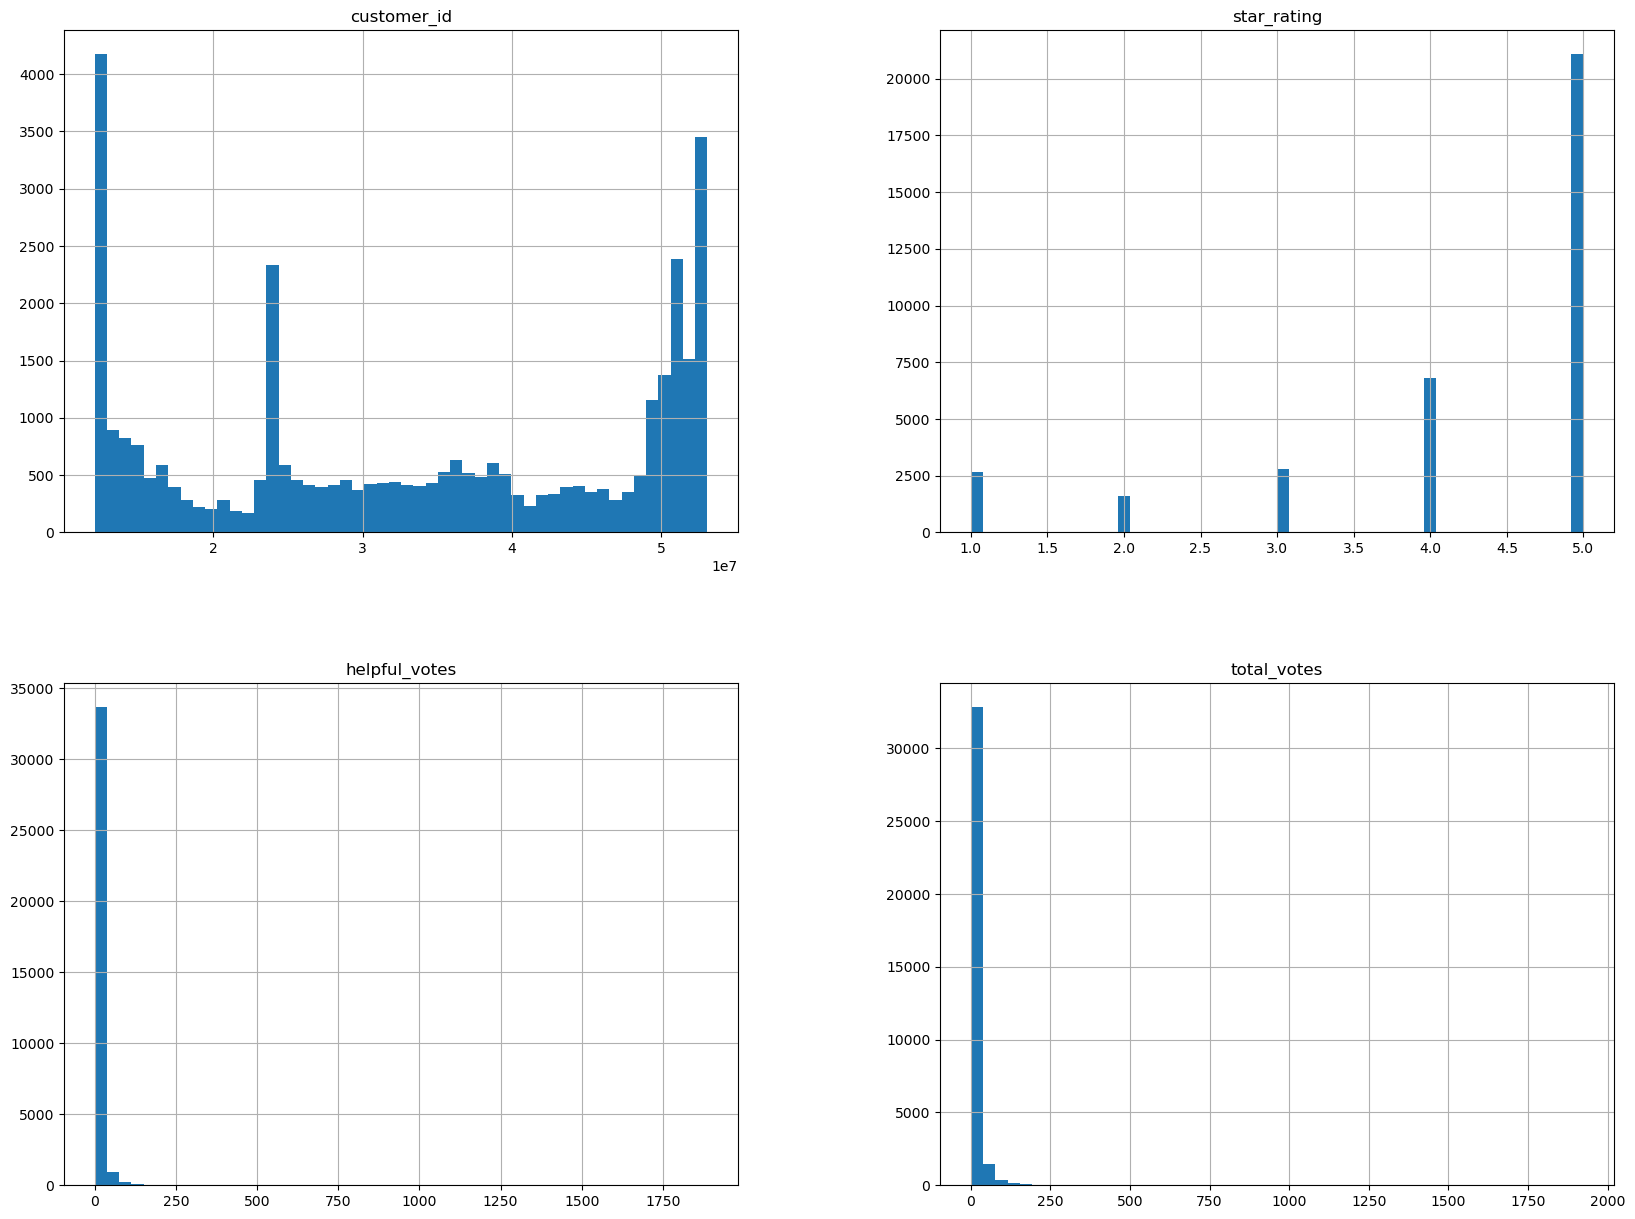

Variables with positive skewness: ['helpful_votes', 'total_votes']

Variables with negative skewness: ['star_rating']

Symmetric variables: ['customer_id']



In [5]:
X = data.drop('product_id', axis=1)
y = data['product_id']

# Divission of the data in trainning and temporal test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Divission of the temporal test in validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print()

X_train_num = X_train.select_dtypes(exclude=["object", "category"])
# Calculate the skewness of the numerical variables in the training set
skew = X_train_num.skew()
print("Skewness of the numerical variables in the training set")
print(skew)
print()

# Histograms of the numerical variables in the training set
X_train_num.hist(bins=50, figsize=(20, 15))
plt.show()

# Variables with positive skewness
pos_skew = X_train_num.columns[skew > 0.5]
print(f"Variables with positive skewness: {pos_skew.to_list()}")
print()

# Variables with negative skewness
neg_skew = X_train_num.columns[skew < -0.5]
print(f"Variables with negative skewness: {neg_skew.to_list()}")
print()

# Symmetric variables
symmetric = X_train_num.columns[(skew >= -0.5) & (skew <= 0.5)]
print(f"Symmetric variables: {symmetric.to_list()}")
print()

X_train_T = X_train.copy()
X_val_T = X_val.copy()
X_test_T = X_test.copy()

# Logarithmic transformation for variables with positive skewness
for col in pos_skew:
    if col in X_train_T.columns:
        X_train_T[col] = np.log1p(X_train[col])
        X_val_T[col] = np.log1p(X_val[col])
        X_test_T[col] = np.log1p(X_test[col])

# Ye-Johnson transformation for variables with negative skewness
pt = PowerTransformer(method='yeo-johnson')
for col in neg_skew:
    if col in X_train_T.columns:
        X_train_T[col] = pt.fit_transform(X_train_T[[col]])
        X_val_T[col] = pt.transform(X_val_T[[col]])
        X_test_T[col] = pt.transform(X_test_T[[col]])

# Standardization of symmetric variables
scaler = StandardScaler()
for col in symmetric:
    if col in X_train_T.columns:
        X_train_T[col] = scaler.fit_transform(X_train_T[[col]])
        X_val_T[col] = scaler.transform(X_val_T[[col]])
        X_test_T[col] = scaler.transform(X_test_T[[col]])


# Label encoding of the categorical variables
le = LabelEncoder()
for col in X_train_T.select_dtypes(include=["object", "category"]).columns:
    X_train_T[col] = le.fit_transform(X_train_T[col])
    X_val_T[col] = le.transform(X_val_T[col])
    X_test_T[col] = le.transform(X_test_T[col])

## Basic Recomendation Algorithm using SVD

In [6]:
customer_id_map = {customer_id: i for i,customer_id in enumerate(X_train_T['customer_id'].unique())}
product_id_map = {product_id: i for i,product_id in enumerate(y_train.unique())}

num_users = len(customer_id_map)
num_products = len(product_id_map)

utility_matrix = np.zeros((num_users, num_products))

for row in X_train_T.itertuples():
    user_index = customer_id_map.get(row.customer_id)
    product_index = product_id_map.get(row.Index)
    if user_index is None or product_index is None:
        continue
    utility_matrix[user_index, product_index] = row.star_rating

print("Utility Matrix Shape:", utility_matrix.shape)

Utility Matrix Shape: (26611, 26403)


In [7]:
U, sigma, Vt = svds(utility_matrix, k=50)
sigma = np.diag(sigma)

In [8]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns=np.arange(num_products))

def recommend_products(user_id, num_recommendations=5):
    sorted_user_predictions = predicted_ratings_df.iloc[user_id].sort_values(ascending=False)
    return sorted_user_predictions.head(num_recommendations)

user_id = 4
recommended_products = recommend_products(user_id)
print(f'Recommended products for user {user_id}: {recommended_products.index.values}')

Recommended products for user 4: [    0 17598 17608 17607 17606]
